In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurav9786/real-time-advertisers-auction")

print("Path to dataset files:", path)

Path to dataset files: /Users/tyf/.cache/kagglehub/datasets/saurav9786/real-time-advertisers-auction/versions/1


In [48]:
import os
import pandas as pd

files = os.listdir(path)
print("files in the dataset", files)

files in the dataset ['Dataset.csv']


In [49]:
file = files[0]
filePath = os.path.join(path, file)
print(filePath)

/Users/tyf/.cache/kagglehub/datasets/saurav9786/real-time-advertisers-auction/versions/1/Dataset.csv


In [50]:
df = pd.read_csv(filePath)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor



In [52]:
print("Dataset shape", df.shape)
print("Column names:")
print(df.columns.tolist())

print("first 5 rows:")
display(df.head())

print("Missing values per column:")
display(df.isnull().sum())

Dataset shape (567291, 17)
Column names:
['date', 'site_id', 'ad_type_id', 'geo_id', 'device_category_id', 'advertiser_id', 'order_id', 'line_item_type_id', 'os_id', 'integration_type_id', 'monetization_channel_id', 'ad_unit_id', 'total_impressions', 'total_revenue', 'viewable_impressions', 'measurable_impressions', 'revenue_share_percent']
first 5 rows:


,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,2019-06-30 00:00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1
1,2019-06-30 00:00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1
2,2019-06-30 00:00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1
3,2019-06-30 00:00:00,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1
4,2019-06-30 00:00:00,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1


Missing values per column:


date                       0
site_id                    0
ad_type_id                 0
geo_id                     0
device_category_id         0
advertiser_id              0
order_id                   0
line_item_type_id          0
os_id                      0
integration_type_id        0
monetization_channel_id    0
ad_unit_id                 0
total_impressions          0
total_revenue              0
viewable_impressions       0
measurable_impressions     0
revenue_share_percent      0
dtype: int64

CPM statistics:


count    377753.000000
mean          1.719923
std           8.865437
min          -7.009091
10%           0.000000
25%           0.000000
50%           0.436641
70%           1.500000
90%           4.200000
95%           6.900000
max        2836.200000
Name: cpm, dtype: float64

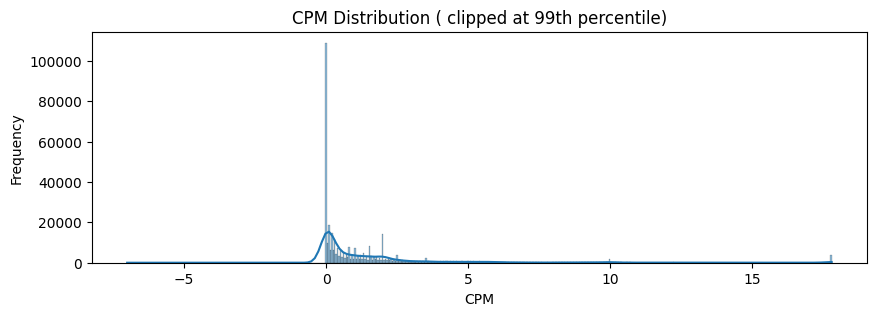

In [53]:
#Calulate CPM as our proxy for bid values
df['cpm'] = (df['total_revenue'] / df['total_impressions']) * 1000

#Handle potential division by zero or very small impression counts
df = df[df['total_impressions'] > 0] # Remove rows with zero impressions
df = df[~df['cpm'].isin([np.inf, -np.inf])] # Remove infinite CPM values
df = df.dropna(subset=['cpm']) # Remove rows with NaN CPM values

# Examine the calculated CPM
print("CPM statistics:")
display(df['cpm'].describe(percentiles=[.1,.25,.5,.7,.9,.95]))

#Visualize CPM distribution
plt.figure(figsize=(10,3))
sns.histplot(df['cpm'].clip(upper=df['cpm'].quantile(0.99)), kde=True)
plt.title('CPM Distribution ( clipped at 99th percentile)')
plt.xlabel('CPM')
plt.ylabel('Frequency')
plt.show()


Total number of segments: 80
Segments with at least 30 observations: 65


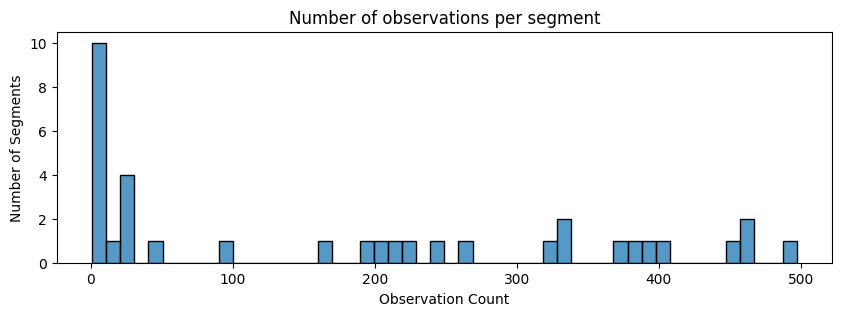


Top 10 segments by impression volume:


segment
349_10_2    2140542
350_10_2    1789002
351_10_1    1784356
343_10_2    1148386
346_10_2    1146626
349_10_1     930880
345_10_1     910956
350_10_1     793648
350_10_3     746782
345_10_2     737264
Name: total_impressions, dtype: int64

In [54]:
# Create a segmentation strategy based on key dimensions
# Start iwht a simpler segmentation and can refine later
df['segment'] = df['site_id'].astype(str) + '_' + df['ad_type_id'].astype(str) + '_' + df['device_category_id'].astype(str)

# Count observations per segment
segment_counts = df['segment'].value_counts()
print(f"Total number of segments: {len(segment_counts)}")
print(f"Segments with at least 30 observations: {sum(segment_counts >= 30)}")

# Display distribution of observations per segment 
plt.figure(figsize=(10,3))
sns.histplot(segment_counts[segment_counts < 500], bins=50) # Limit to smaller segments for better visualization
plt.title("Number of observations per segment")
plt.xlabel("Observation Count")
plt.ylabel("Number of Segments")
plt.show()

# Identify and siplay top segments by impression volume
top_segments = df.groupby('segment')['total_impressions'].sum().nlargest(10)
print("\nTop 10 segments by impression volume:")
display(top_segments)

Statistics calculated for 65 segments with at least 30 observations


,count,mean,std,min,p30,p50,p70,max
segment,,,,,,,,
342_10_1,7220,2.902163,13.196399,0.0,0.300000,1.200000,2.3,659.275000
342_10_2,4095,2.139841,6.682378,0.0,0.050000,0.800000,2.0,244.966667
342_10_3,4424,2.474897,43.370430,0.0,0.133333,0.884524,1.9,2836.200000
342_17_1,459,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
342_17_2,404,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


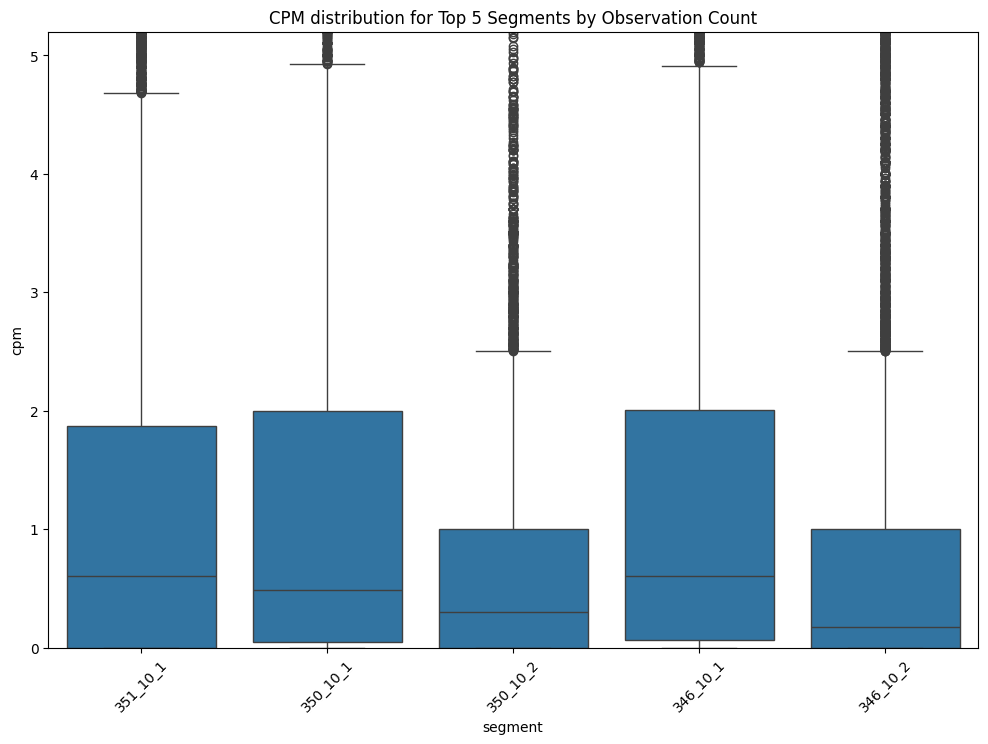

In [55]:
# Calculate CPM statistics for each segment
segment_stats = df.groupby('segment')['cpm'].agg([
    'count', 'mean', 'std', 'min', 
    lambda x: np.percentile(x, 30),  # 30th percentile
    lambda x: np.percentile(x, 50),  # median (50th percentile)
    lambda x: np.percentile(x, 70),  # 70th percentile
    'max'
]).rename(columns={'<lambda_0>': 'p30', '<lambda_1>': 'p50', '<lambda_2>': 'p70'})

# Filter segments with enough data for reliable statistics
min_observations = 30  # Minimum number of observations per segment
valid_segments = segment_stats[segment_stats['count'] >= min_observations].copy()

print(f"Statistics calculated for {len(valid_segments)} segments with at least {min_observations} observations")
display(valid_segments.head())

# Visualize CPM distribution for top segments
top_segment_names = valid_segments.nlargest(5, 'count').index
top_segments_df = df[df['segment'].isin(top_segment_names)]

plt.figure(figsize=(12,8))
sns.boxplot(data=top_segments_df, x='segment', y='cpm')
plt.title('CPM distribution for Top 5 Segments by Observation Count')
plt.xticks(rotation=45)
plt.ylim(0, top_segments_df['cpm'].quantile(0.95)) # Limit y-axis for better visualization
plt.show()


In [56]:
# Main Task: Set floor prices at the 30th percentile of each segment's CPM
# This gives us ~70% configdence that bids will be above this price
floor_prices = valid_segments[['p30']].rename(columns={'p30' : 'floor_price'})

# Display the first few floor prices
print("Floor prices for a few segments (30th percentile of CPM):")
display(floor_prices.head())


# Add segment information for better readability
# Extract segment component

segment_components = pd.DataFrame([
    segment.split('_') for segment in floor_prices.index
], columns=['site_id', 'ad_type_id', 'device_category_id'], index=floor_prices.index)

# Join with floor prices

floor_prices_with_info = floor_prices.join((segment_components))

# Dislay more readable format
display(floor_prices_with_info.head())

# Optionally save floor prices to CSV 
floor_prices_with_info.reset_index().to_csv('floor_prices.csv', index=False)
print("Floor prices saved to 'floor_rices.csv")

Floor prices for a few segments (30th percentile of CPM):


,floor_price
segment,
342_10_1,0.300000
342_10_2,0.050000
342_10_3,0.133333
342_17_1,0.000000
342_17_2,0.000000


,floor_price,site_id,ad_type_id,device_category_id
segment,,,,
342_10_1,0.300000,342,10,1
342_10_2,0.050000,342,10,2
342_10_3,0.133333,342,10,3
342_17_1,0.000000,342,17,1
342_17_2,0.000000,342,17,2


Floor prices saved to 'floor_rices.csv


,segment,reserve_price,failure_rate,success_rate
0,342_10_2,0.000000,0.374400,6.255998e-01
1,342_10_2,27.218519,0.999913,8.738047e-05
2,342_10_2,54.437037,1.000000,2.553513e-15
3,342_10_2,81.655556,1.000000,0.000000e+00
4,342_10_2,108.874074,1.000000,0.000000e+00
5,342_10_2,136.092593,1.000000,0.000000e+00
6,342_10_2,163.311111,1.000000,0.000000e+00
7,342_10_2,190.529630,1.000000,0.000000e+00
8,342_10_2,217.748148,1.000000,0.000000e+00
9,342_10_2,244.966667,1.000000,0.000000e+00


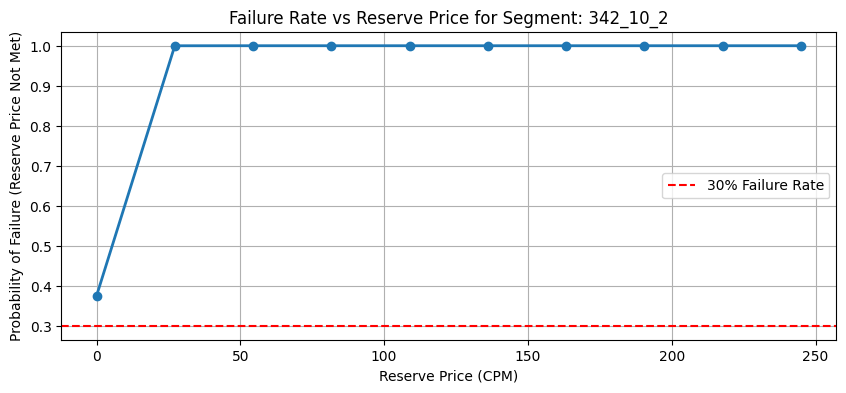

In [57]:
# Auxiliary Task: Function to predict failure rate for a given reserve price
def predict_failure_rate(segment, reserve_price, stats_df=segment_stats):
    """
    Predict the probability that a reserve price will not be met for a given segment

    Params:

    segment: str
        The segment identifier
    
    reserve_price : float
        The proposed reserve price
    
    stats_df : pandas.DataFrame
        DataFrame containing segment statistics
    """
    if segment not in stats_df.index:
        return None
    
    # Get segment statistics
    segment_mean = stats_df.loc[segment, 'mean']
    segment_std = stats_df.loc[segment, 'std']

    #Handle segments with insufficient data or zero standard deviation
    if pd.isna(segment_std) or segment_std == 0:
        # Use a simple heuristic based on the mean
        if reserve_price < segment_mean:
            return 0.3 # Arbitrary value, should be refined
        else:
            return 0.7
        
    # Use normal approximation for the distribution of bids
    # This is a simplification - real bid ditribution are often log-normal

    z_score = (reserve_price - segment_mean) / segment_std
    failure_rate = stats.norm.cdf(z_score)

    return failure_rate

# Example usage - test various reserve prices for a sample segment
sample_segment = valid_segments.index[1]
test_prices = np.linspace(
    valid_segments.loc[sample_segment, 'min'],
    valid_segments.loc[sample_segment, 'max'],
    10
)

results = []
for price in test_prices:
    failure_rate = predict_failure_rate(sample_segment, price)
    results.append({
        'segment': sample_segment,
        'reserve_price' : price,
        'failure_rate': failure_rate,
        'success_rate': 1 - failure_rate
    })

results_df = pd.DataFrame(results)
display(results_df)

#Visualize the failure rate curve
plt.figure(figsize=(10,4))
plt.plot(results_df['reserve_price'], results_df['failure_rate'], 'o-', linewidth=2)
plt.axhline(y=0.3, color='r', linestyle='--', label='30% Failure Rate')
plt.title(f'Failure Rate vs Reserve Price for Segment: {sample_segment}')
plt.xlabel('Reserve Price (CPM)')
plt.ylabel('Probability of Failure (Reserve Price Not Met)')
plt.grid(True)
plt.legend()
plt.show()


Performance Summary:
Auction Success Rate: 80.43%
Original Revenue: $39,562.49
Potential Revenue with Floor Prices: $39,421.46
Revenue Lift: -0.36%


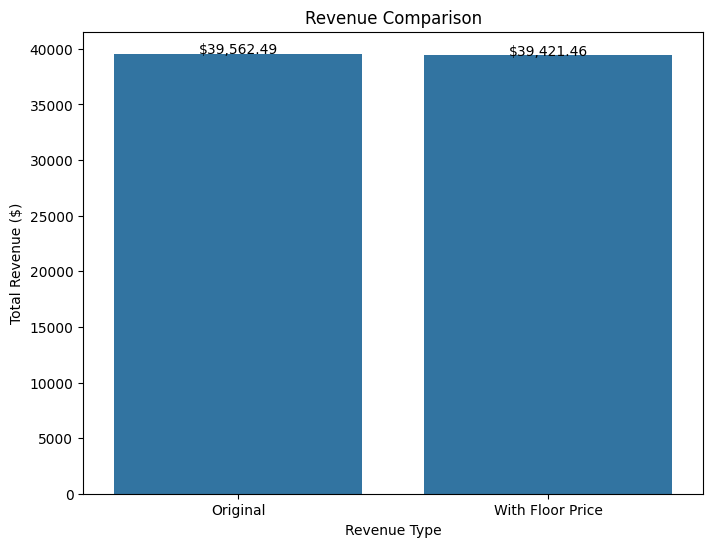

In [62]:
# Evaluate how our floor prices would have performed on historical data
df_eval = df[df['segment'].isin(valid_segments.index)].copy()

# Merge floor prices with the original data
df_eval = pd.merge(
    df_eval,
    floor_prices.reset_index(),
    on='segment',
    how='left'
)

# Calculate if auction would succeed with our floor price
df_eval['auction_success'] = df_eval['cpm'] >= df_eval['floor_price']

# Calculate revenue under different scenarios
df_eval['original_revenue'] = df_eval['total_revenue']
df_eval['potential_revenue'] = np.where(
    df_eval['auction_success'],
    df_eval['total_revenue'],  # Keep original revenue when auction succeeds
    0  # Zero revenue when auction fails
)

# Overall performance metrics
success_rate = df_eval['auction_success'].mean()
original_total = df_eval['original_revenue'].sum()
potential_total = df_eval['potential_revenue'].sum()
revenue_lift = (potential_total / original_total - 1) * 100

print(f"Performance Summary:")
print(f"Auction Success Rate: {success_rate:.2%}")
print(f"Original Revenue: ${original_total:,.2f}")
print(f"Potential Revenue with Floor Prices: ${potential_total:,.2f}")
print(f"Revenue Lift: {revenue_lift:.2f}%")

# Visualize original vs potential revenue
comparison = pd.DataFrame({
    'Revenue Type': ['Original', 'With Floor Price'],
    'Revenue': [original_total, potential_total]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Revenue Type', y='Revenue', data=comparison)
plt.title('Revenue Comparison')
plt.ylabel('Total Revenue ($)')
for i, v in enumerate(comparison['Revenue']):
    plt.text(i, v + 0.1, f'${v:,.2f}', ha='center')
plt.show()

,confidence_level,percentile,success_rate,test_revenue,original_revenue,revenue_lift
0,0.5,50,0.527331,38475.2580,39562.492,-2.748143
1,0.6,40,0.625510,39183.6998,39562.492,-0.957453
2,0.7,30,0.804278,39421.4606,39562.492,-0.356478
3,0.8,20,0.961913,39493.0224,39562.492,-0.175595
4,0.9,10,0.999936,39498.1862,39562.492,-0.162542


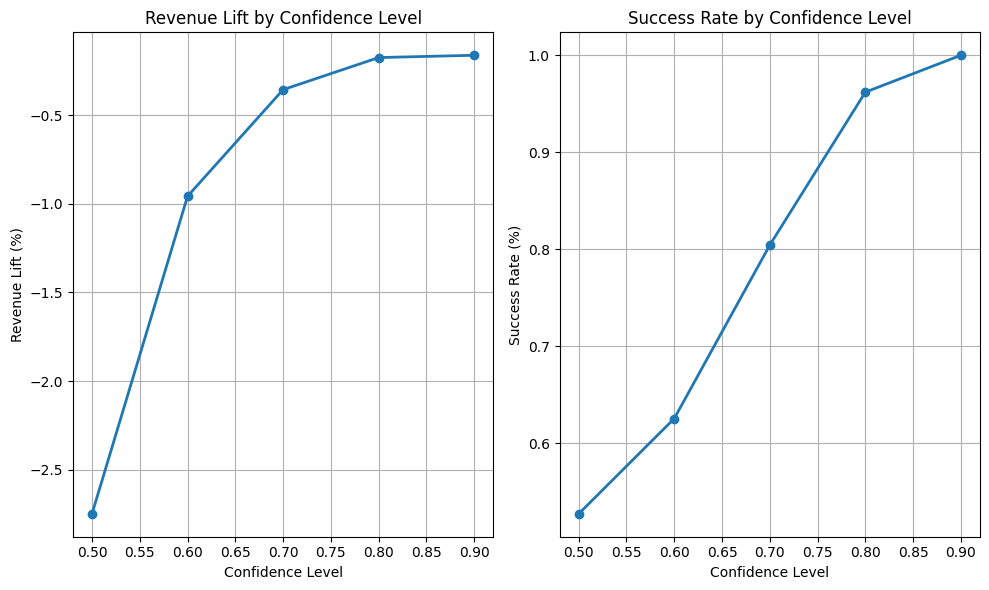

Optimal Confidence Level: 0.9
Corresponding Percentile: 10.0
Expected Revenue Lift: -0.16%
Expected Success Rate: 99.99%


In [64]:
# Test different confidence levels to find the optimal one
confidence_levels = [0.5,0.6,0.7,0.8,0.9]
percentiles = [50,40,30,20,10] # Corresponding percentiles

results = []

for cl, perc in zip(confidence_levels, percentiles):

    # Set floor price at the specified pecentile
    floor_price_col = f'p{perc}'
    if floor_price_col not in valid_segments.columns and perc in [10,20,40]:
        # CAlculate these percentiles if they don't exist
        valid_segments[floor_price_col] = df.groupby('segment')['cpm'].agg(
            lambda x: np.percentile(x,perc)
        ).reindex(valid_segments.index)

    # Merge floor prices with original data
    temp_df = df[df['segment'].isin(valid_segments.index)].copy()
    temp_df = pd.merge(
        temp_df,
        valid_segments[[floor_price_col]].rename(columns={floor_price_col: 'test_floor_price'}).reset_index(),
        on='segment',
        how='left'
    )

    # Calculate success and revenue
    temp_df['success'] = temp_df['cpm'] >= temp_df['test_floor_price']
    temp_df['test_revenue'] = np.where(
        temp_df['success'],
        temp_df['total_revenue'],
        0
    )

    # Calculate metrics 
    success_rate = temp_df['success'].mean()
    test_revenue = temp_df['test_revenue'].sum()
    original_revenue = temp_df['total_revenue'].sum()
    revenue_lift = (test_revenue / original_revenue -1 ) * 100

    results.append({
        'confidence_level': cl,
        'percentile': perc,
        'success_rate': success_rate,
        'test_revenue': test_revenue,
        'original_revenue': original_revenue,
        'revenue_lift': revenue_lift
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df)

# Visualize impact of different confidence levls
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(results_df['confidence_level'], results_df['revenue_lift'], 'o-', linewidth=2)
plt.title('Revenue Lift by Confidence Level')
plt.xlabel('Confidence Level')
plt.ylabel('Revenue Lift (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df['confidence_level'], results_df['success_rate'], 'o-', linewidth=2)
plt.title('Success Rate by Confidence Level')
plt.xlabel('Confidence Level')
plt.ylabel('Success Rate (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal confidence level
optimal_row = results_df.loc[results_df['revenue_lift'].idxmax()]
print(f"Optimal Confidence Level: {optimal_row['confidence_level']:.1f}")
print(f"Corresponding Percentile: {optimal_row['percentile']}")
print(f"Expected Revenue Lift: {optimal_row['revenue_lift']:.2f}%")
print(f"Expected Success Rate: {optimal_row['success_rate']:.2%}")

Training set: 302202 samples
Test set: 75551 samples
Model Performance:
RMSE: 13.05
MAE: 1.51


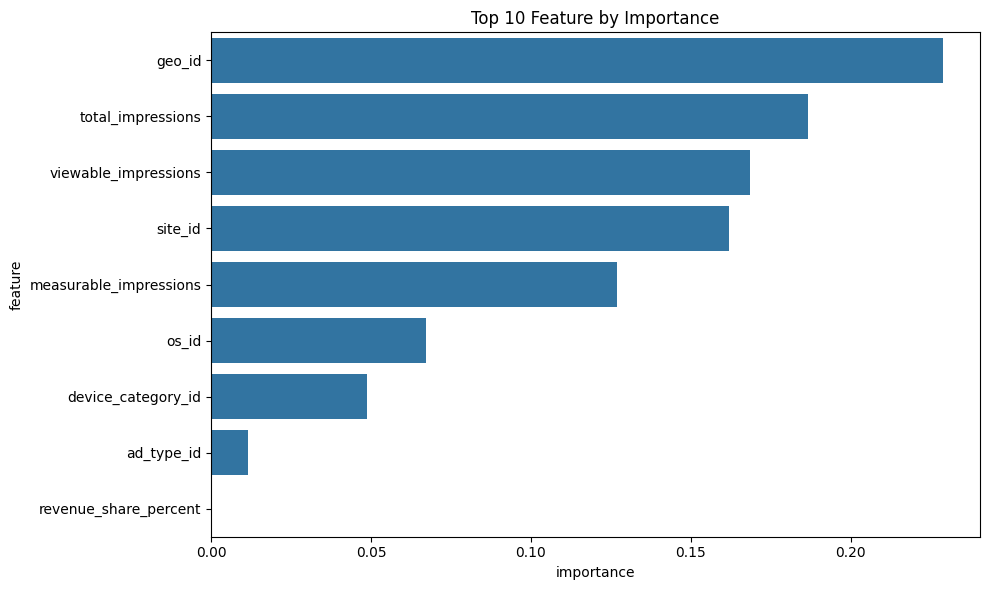

In [60]:
# Build a predictive model for CPM
# This can help generalize to new segments or provide more accurate estimates

categorical_features = ['site_id', 'ad_type_id', 'geo_id', 'device_category_id', 'os_id']
numerical_features = ['total_impressions', 'viewable_impressions', 'measurable_impressions', 'revenue_share_percent']

X = df[categorical_features + numerical_features].copy()

# Convert categorial columsn to category type
for col in categorical_features:
    X[col] =X[col].astype('category')

# Target variable
y = df['cpm']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train a Random Forest model

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=1,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Feature importance

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature by Importance')
plt.tight_layout()
plt.show()

# This model can be used to predict CPM for segments